In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets

import matplotlib.pyplot as plt
import tqdm

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(600))
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(100))
# train is 6000 long
# test is 1000 long

In [41]:
# Initialize network and optimizer
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Function to train the model
def train(epoch, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


In [42]:
# Function to test the model
def test(test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

In [43]:
accuracies = []
for i in range(9):
    for j in range(i+1, 10):
        train_loader = torch.utils.data.DataLoader([x for x in train_dataset if x[1] == i or x[1] == j])
        test_loader = torch.utils.data.DataLoader([x for x in test_dataset if x[1] == i or x[1] == j])
        train(epoch, train_loader)
        accuracies.append(test(test_loader))
        print(f'task: {i} vs {j}, accuracy: {accuracies[-1]}')

task: 0 vs 1, accuracy: 1.0
task: 0 vs 2, accuracy: 1.0
task: 0 vs 3, accuracy: 0.8421052631578947
task: 0 vs 4, accuracy: 0.9545454545454546
task: 0 vs 5, accuracy: 1.0
task: 0 vs 6, accuracy: 1.0
task: 0 vs 7, accuracy: 1.0
task: 0 vs 8, accuracy: 1.0
task: 0 vs 9, accuracy: 1.0
task: 1 vs 2, accuracy: 0.8181818181818182
task: 1 vs 3, accuracy: 0.8
task: 1 vs 4, accuracy: 0.9285714285714286
task: 1 vs 5, accuracy: 1.0
task: 1 vs 6, accuracy: 1.0
task: 1 vs 7, accuracy: 0.9655172413793104
task: 1 vs 8, accuracy: 1.0
task: 1 vs 9, accuracy: 1.0
task: 2 vs 3, accuracy: 1.0
task: 2 vs 4, accuracy: 0.9545454545454546
task: 2 vs 5, accuracy: 0.9333333333333333
task: 2 vs 6, accuracy: 1.0
task: 2 vs 7, accuracy: 1.0
task: 2 vs 8, accuracy: 1.0
task: 2 vs 9, accuracy: 1.0
task: 3 vs 4, accuracy: 1.0
task: 3 vs 5, accuracy: 0.9444444444444444
task: 3 vs 6, accuracy: 1.0
task: 3 vs 7, accuracy: 0.9615384615384616
task: 3 vs 8, accuracy: 1.0
task: 3 vs 9, accuracy: 1.0
task: 4 vs 5, accuracy: 0

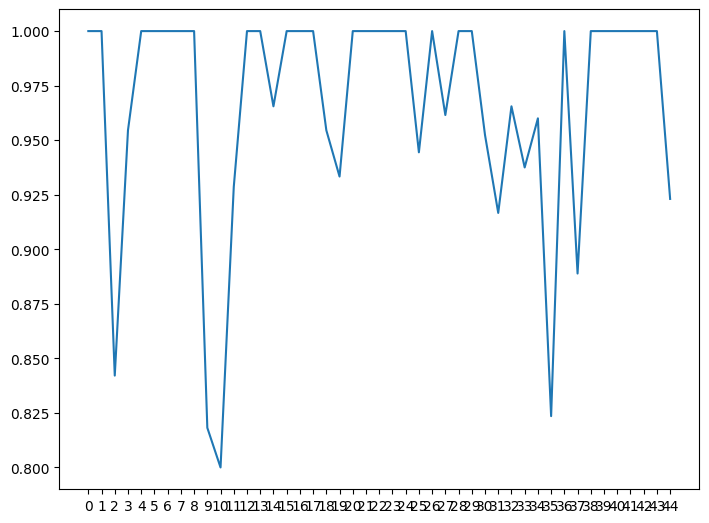

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot([str(i) for i in range(45)], accuracies)
plt.show()